##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
%pip install pandas 
%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [1]:
# Can have as many cells as you want for code
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [7]:
###...code...###
df = pd.read_csv(filepath)
df.head
df.shape

# check if global ultimate company = domestic ultimate company means domestic sale = global sale
a = df.loc[df['Global Ultimate Company'] == df['Domestic Ultimate Company']] 
b = a.loc[df['Sales (Domestic Ultimate Total USD)'] != df['Sales (Global Ultimate Total USD)']]

a.shape #(18566, 28) 
b.shape #(18545, 28)

df['Industry'].nunique() # too many industries 580
df['8-Digit SIC Description'].nunique() #2191
df['8-Digit SIC Code'].nunique() #2255
df['SIC Code'].nunique() #582
c = df.loc[df['SIC Code']>1799]
d = c.loc[c['SIC Code']<4000]


df.loc[df['Entity Type']=='Independent']
df.loc[df['Sales (Domestic Ultimate Total USD)'] > df['Sales (Global Ultimate Total USD)']] #2675

df.shape

29182 *  0.01487218



433.99995676000003

In [8]:
## replace the SIC Code with Sector name
new_df = df.copy()

new_df.loc[new_df['SIC Code'].between(100, 999), 'SIC Industry'] = 'Agriculture'

In [9]:
## Replace missing values in Year Found by the median 2008 

new_df['Year Found'].describe()

new_df['Year Found'] = new_df['Year Found'].fillna(2008)


new_df['Year Found'].describe()
df['Year Found'].describe()

len(df.loc[df['Year Found']==2008])
len(new_df.loc[new_df['Year Found']==2008])




1550

In [10]:
## Replace missing values in Employees (Domestic Ultimate Total) with mean 

new_df['Employees (Domestic Ultimate Total)'].describe() #mean = 139.764182
# new_df.loc[new_df['Employees (Domestic Ultimate Total)'] == 80000]

a = new_df[new_df['Employees (Domestic Ultimate Total)']<50000] ## remove the two rows where they have 80000 workers

a['Employees (Domestic Ultimate Total)'].describe() #mean = 134.275695


count    29101.000000
mean       134.275695
std        902.083150
min          1.000000
25%          4.000000
50%         16.000000
75%         60.000000
max      40000.000000
Name: Employees (Domestic Ultimate Total), dtype: float64

In [11]:

variables_to_remove = [
    'LATITUDE', 'LONGITUDE', 'AccountID', 'Company', '8-Digit SIC Code',
    '8-Digit SIC Description', 'Company Description', 'Company Status (Active/Inactive)',
    'Fiscal Year End', 'Is Global Ultimate', 'Global Ultimate Company',
    'Global Ultimate Country', 'Industry', 'Square Footage', 'Employees (Single Site)', 'Sales (Global Ultimate Total USD)', 'Employees (Global Ultimate Total)'
]
df = new_df.drop(variables_to_remove, axis=1)
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29182 entries, 0 to 29181
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SIC Code                             29182 non-null  float64
 1   Year Found                           29182 non-null  float64
 2   Entity Type                          29182 non-null  object 
 3   Parent Company                       28668 non-null  object 
 4   Parent Country                       28662 non-null  object 
 5   Ownership Type                       29182 non-null  object 
 6   Employees (Domestic Ultimate Total)  29103 non-null  float64
 7   Sales (Domestic Ultimate Total USD)  29182 non-null  float64
 8   Import/Export Status                 6613 non-null   object 
 9   Domestic Ultimate Company            28147 non-null  object 
 10  Is Domestic Ultimate                 29182 non-null  float64
 11  SIC Industry                

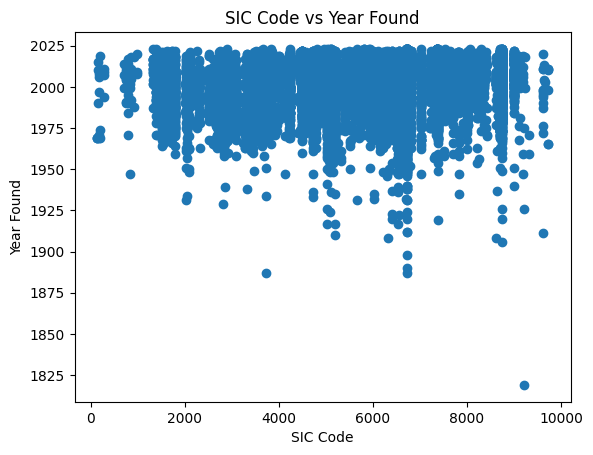

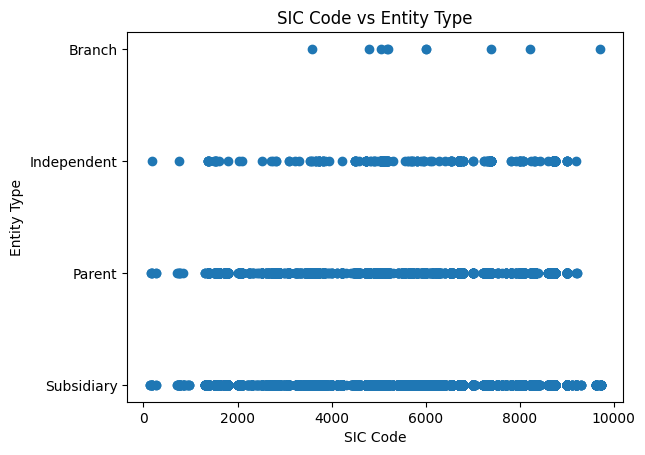

Error plotting SIC Code vs Parent Company: 'value' must be an instance of str or bytes, not a float
Error plotting SIC Code vs Parent Country: Failed to convert value(s) to axis units: 0             Singapore
1             Singapore
2         Hong Kong SAR
3             Singapore
4             Singapore
              ...      
29177     Hong Kong SAR
29178               NaN
29179    United Kingdom
29180         Singapore
29181         Singapore
Name: Parent Country, Length: 29182, dtype: object
Error plotting SIC Code vs Ownership Type: Failed to convert value(s) to axis units: 0        Private
1        Private
2        Private
3        Private
4        Private
          ...   
29177    Private
29178    Private
29179     Public
29180    Private
29181    Private
Name: Ownership Type, Length: 29182, dtype: object


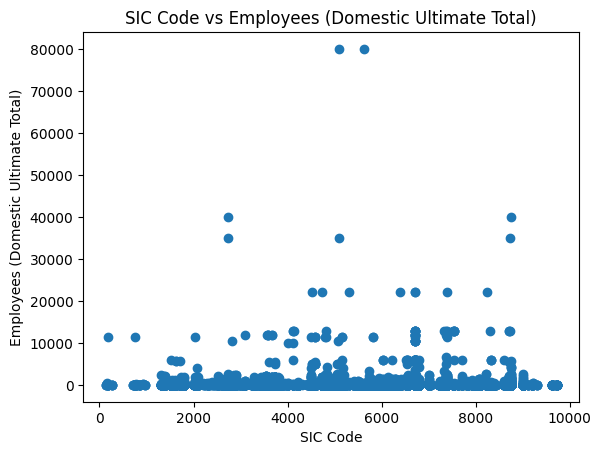

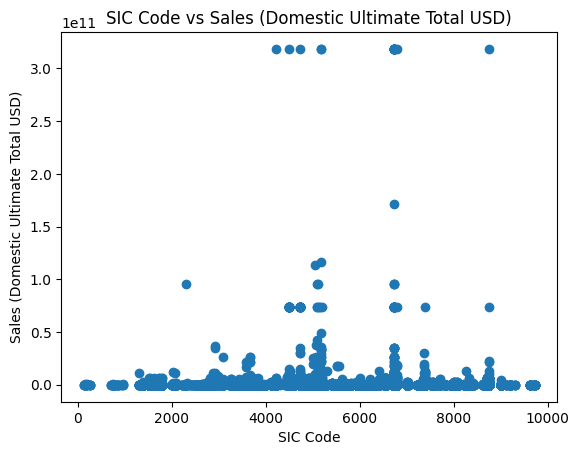

Error plotting SIC Code vs Import/Export Status: 'value' must be an instance of str or bytes, not a float
Error plotting SIC Code vs Domestic Ultimate Company: Failed to convert value(s) to axis units: 0                FRANK RECRUITMENT GROUP PRIVATE LTD.
1                                                 NaN
2                         2MBAO BIOCELLBANK PTE. LTD.
3                        WILMAR INTERNATIONAL LIMITED
4                        ASIA GREEN CAPITAL PTE. LTD.
                             ...                     
29177    DYSTAR GLOBAL HOLDINGS (SINGAPORE) PTE. LTD.
29178                                             NaN
29179                              ABRDN ASIA LIMITED
29180                     65EP INVESTMENT I PTE. LTD.
29181                      TRUSSCO HOLDINGS PTE. LTD.
Name: Domestic Ultimate Company, Length: 29182, dtype: object


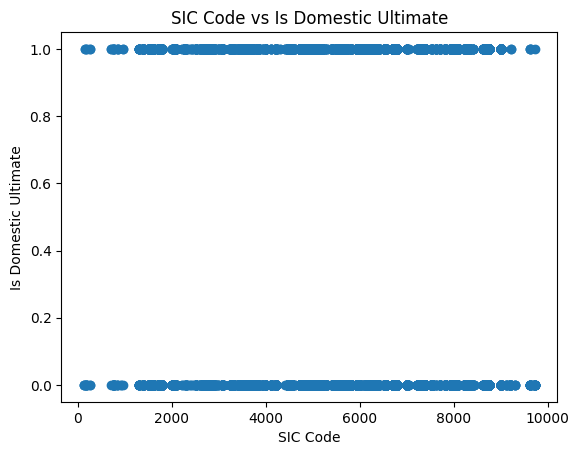

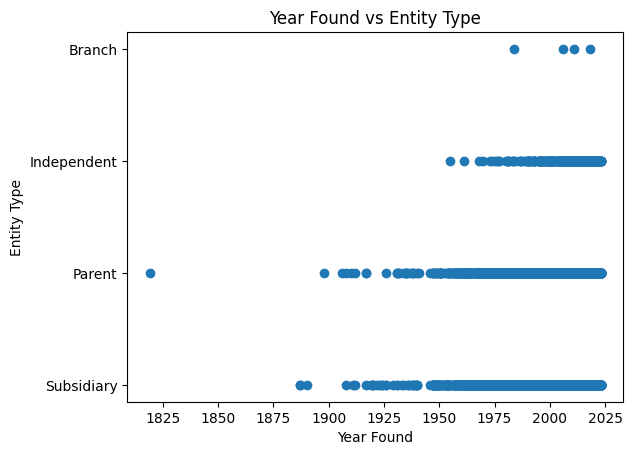

Error plotting Year Found vs Parent Company: 'value' must be an instance of str or bytes, not a float
Error plotting Year Found vs Parent Country: Failed to convert value(s) to axis units: 0             Singapore
1             Singapore
2         Hong Kong SAR
3             Singapore
4             Singapore
              ...      
29177     Hong Kong SAR
29178               NaN
29179    United Kingdom
29180         Singapore
29181         Singapore
Name: Parent Country, Length: 29182, dtype: object
Error plotting Year Found vs Ownership Type: Failed to convert value(s) to axis units: 0        Private
1        Private
2        Private
3        Private
4        Private
          ...   
29177    Private
29178    Private
29179     Public
29180    Private
29181    Private
Name: Ownership Type, Length: 29182, dtype: object


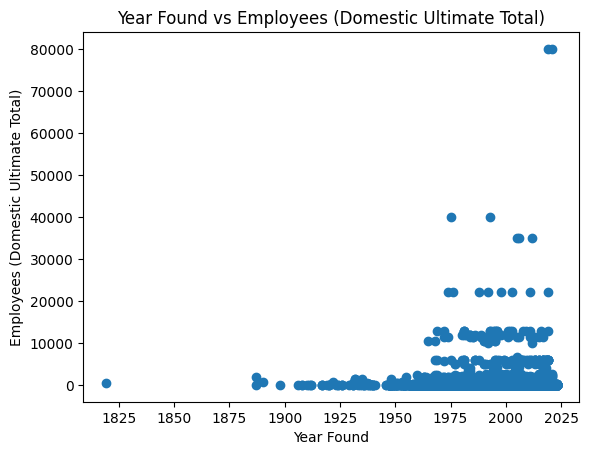

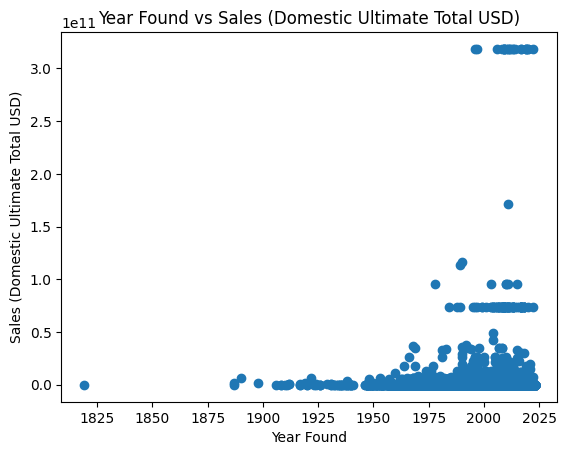

Error plotting Year Found vs Import/Export Status: 'value' must be an instance of str or bytes, not a float
Error plotting Year Found vs Domestic Ultimate Company: Failed to convert value(s) to axis units: 0                FRANK RECRUITMENT GROUP PRIVATE LTD.
1                                                 NaN
2                         2MBAO BIOCELLBANK PTE. LTD.
3                        WILMAR INTERNATIONAL LIMITED
4                        ASIA GREEN CAPITAL PTE. LTD.
                             ...                     
29177    DYSTAR GLOBAL HOLDINGS (SINGAPORE) PTE. LTD.
29178                                             NaN
29179                              ABRDN ASIA LIMITED
29180                     65EP INVESTMENT I PTE. LTD.
29181                      TRUSSCO HOLDINGS PTE. LTD.
Name: Domestic Ultimate Company, Length: 29182, dtype: object


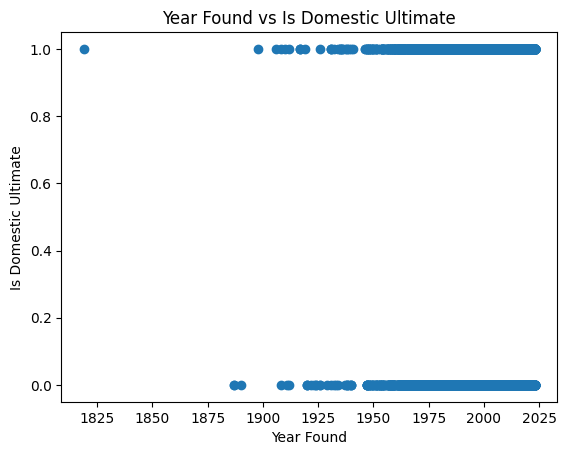

Error plotting Entity Type vs Parent Company: 'value' must be an instance of str or bytes, not a float
Error plotting Entity Type vs Parent Country: Failed to convert value(s) to axis units: 0             Singapore
1             Singapore
2         Hong Kong SAR
3             Singapore
4             Singapore
              ...      
29177     Hong Kong SAR
29178               NaN
29179    United Kingdom
29180         Singapore
29181         Singapore
Name: Parent Country, Length: 29182, dtype: object
Error plotting Entity Type vs Ownership Type: Failed to convert value(s) to axis units: 0        Private
1        Private
2        Private
3        Private
4        Private
          ...   
29177    Private
29178    Private
29179     Public
29180    Private
29181    Private
Name: Ownership Type, Length: 29182, dtype: object


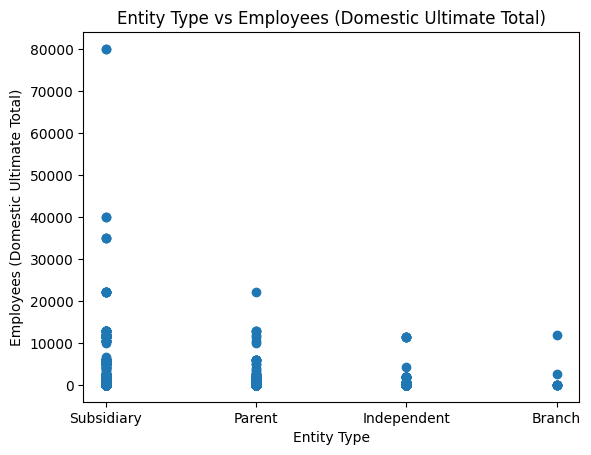

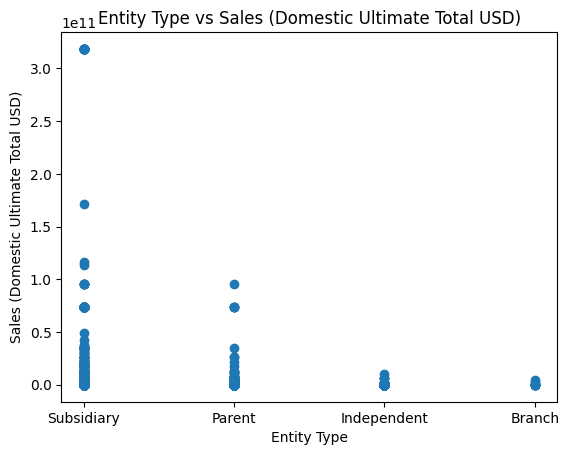

Error plotting Entity Type vs Import/Export Status: 'value' must be an instance of str or bytes, not a float
Error plotting Entity Type vs Domestic Ultimate Company: Failed to convert value(s) to axis units: 0                FRANK RECRUITMENT GROUP PRIVATE LTD.
1                                                 NaN
2                         2MBAO BIOCELLBANK PTE. LTD.
3                        WILMAR INTERNATIONAL LIMITED
4                        ASIA GREEN CAPITAL PTE. LTD.
                             ...                     
29177    DYSTAR GLOBAL HOLDINGS (SINGAPORE) PTE. LTD.
29178                                             NaN
29179                              ABRDN ASIA LIMITED
29180                     65EP INVESTMENT I PTE. LTD.
29181                      TRUSSCO HOLDINGS PTE. LTD.
Name: Domestic Ultimate Company, Length: 29182, dtype: object


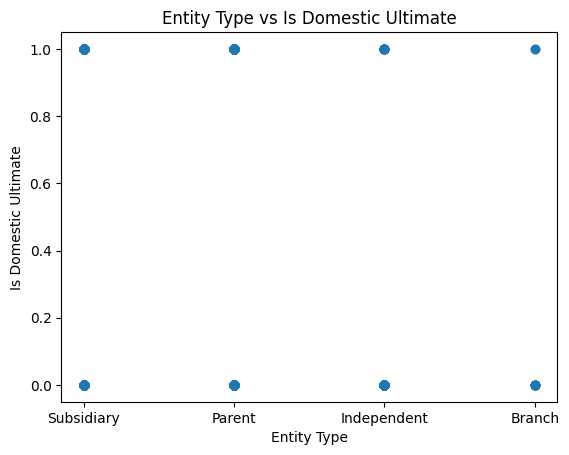

Error plotting Parent Company vs Parent Country: 'value' must be an instance of str or bytes, not a float
Error plotting Parent Company vs Ownership Type: Failed to convert value(s) to axis units: 0        FRANK RECRUITMENT GROUP PRIVATE LTD.
1                FORTITUDE SHIPPING PTE. LTD.
2         MADISON LIGHTERS AND WATCHES CO LTD
3                WILMAR INTERNATIONAL LIMITED
4                ASIA GREEN CAPITAL PTE. LTD.
                         ...                 
29177     SENDA INTERNATIONAL CAPITAL LIMITED
29178                                     NaN
29179                  ABRDN HOLDINGS LIMITED
29180        ENCYCLIA 1 INVESTMENTS PTE. LTD.
29181              TRUSSCO HOLDINGS PTE. LTD.
Name: Parent Company, Length: 29182, dtype: object
Error plotting Parent Company vs Employees (Domestic Ultimate Total): Failed to convert value(s) to axis units: 0        FRANK RECRUITMENT GROUP PRIVATE LTD.
1                FORTITUDE SHIPPING PTE. LTD.
2         MADISON LIGHTERS AND WATCHES CO 

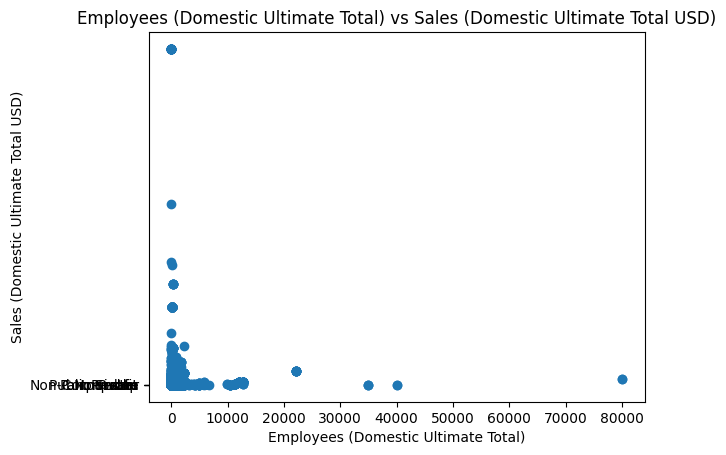

Error plotting Employees (Domestic Ultimate Total) vs Import/Export Status: 'value' must be an instance of str or bytes, not a float
Error plotting Employees (Domestic Ultimate Total) vs Domestic Ultimate Company: Failed to convert value(s) to axis units: 0                FRANK RECRUITMENT GROUP PRIVATE LTD.
1                                                 NaN
2                         2MBAO BIOCELLBANK PTE. LTD.
3                        WILMAR INTERNATIONAL LIMITED
4                        ASIA GREEN CAPITAL PTE. LTD.
                             ...                     
29177    DYSTAR GLOBAL HOLDINGS (SINGAPORE) PTE. LTD.
29178                                             NaN
29179                              ABRDN ASIA LIMITED
29180                     65EP INVESTMENT I PTE. LTD.
29181                      TRUSSCO HOLDINGS PTE. LTD.
Name: Domestic Ultimate Company, Length: 29182, dtype: object


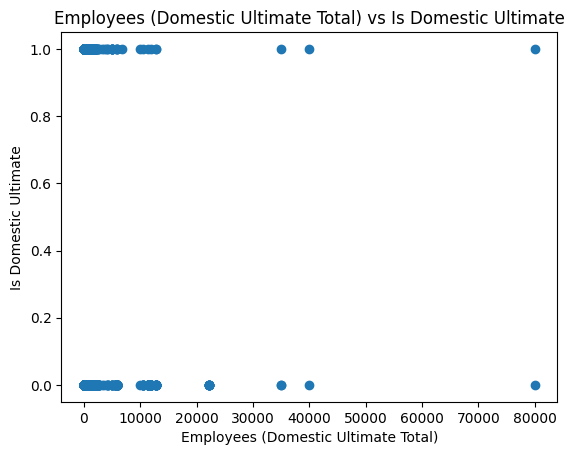

Error plotting Sales (Domestic Ultimate Total USD) vs Import/Export Status: 'value' must be an instance of str or bytes, not a float
Error plotting Sales (Domestic Ultimate Total USD) vs Domestic Ultimate Company: Failed to convert value(s) to axis units: 0                FRANK RECRUITMENT GROUP PRIVATE LTD.
1                                                 NaN
2                         2MBAO BIOCELLBANK PTE. LTD.
3                        WILMAR INTERNATIONAL LIMITED
4                        ASIA GREEN CAPITAL PTE. LTD.
                             ...                     
29177    DYSTAR GLOBAL HOLDINGS (SINGAPORE) PTE. LTD.
29178                                             NaN
29179                              ABRDN ASIA LIMITED
29180                     65EP INVESTMENT I PTE. LTD.
29181                      TRUSSCO HOLDINGS PTE. LTD.
Name: Domestic Ultimate Company, Length: 29182, dtype: object


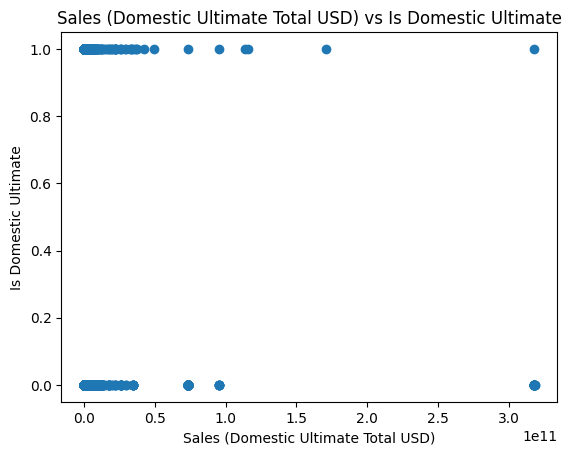

Error plotting Import/Export Status vs Domestic Ultimate Company: 'value' must be an instance of str or bytes, not a float
Error plotting Import/Export Status vs Is Domestic Ultimate: could not convert string to float: 'Exports'
Error plotting Domestic Ultimate Company vs Is Domestic Ultimate: Failed to convert value(s) to axis units: 0                FRANK RECRUITMENT GROUP PRIVATE LTD.
1                                                 NaN
2                         2MBAO BIOCELLBANK PTE. LTD.
3                        WILMAR INTERNATIONAL LIMITED
4                        ASIA GREEN CAPITAL PTE. LTD.
                             ...                     
29177    DYSTAR GLOBAL HOLDINGS (SINGAPORE) PTE. LTD.
29178                                             NaN
29179                              ABRDN ASIA LIMITED
29180                     65EP INVESTMENT I PTE. LTD.
29181                      TRUSSCO HOLDINGS PTE. LTD.
Name: Domestic Ultimate Company, Length: 29182, dtype: object


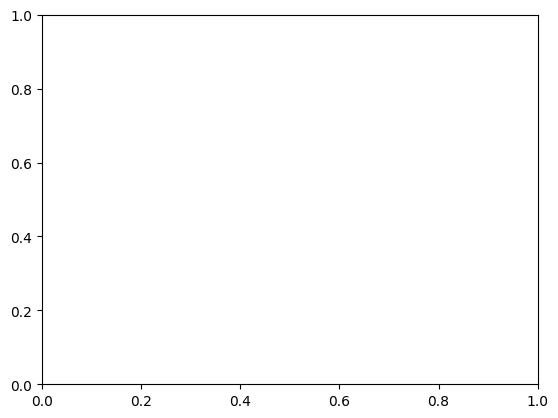

In [4]:
variables = df.columns

# Creating scatter plots
for i in range(len(variables)):
    for j in range(i + 1, len(variables)):
        try:
            plt.scatter(df[variables[i]], df[variables[j]])
            plt.title(f'{variables[i]} vs {variables[j]}')
            plt.xlabel(variables[i])
            plt.ylabel(variables[j])
            plt.show()
        except Exception as e:
            print(f"Error plotting {variables[i]} vs {variables[j]}: {e}")


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [11]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!